# State Farm Distracted Driver Detection - implemented from scratch without using VGG16

### First get standard boilerplate imports out of the way

In [1]:
%matplotlib inline

In [44]:
from __future__ import division,print_function

import os, json, glob, csv
from time import time
#from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

### Define path and batch_size for desired data source

In [3]:
batch_size = 64

In [4]:
#path = "data/"
#test_path = "data/test/"

path = "data/sample/"
test_path = "data/sample/test/"


In [45]:
def get_image_driver_mapping():
    image_driver_mapping = {}
    path = os.path.join('data', 'driver_imgs_list.csv')
    with open(path, 'rb') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        for row in csvreader:
            driver_id = row[0]
            class_id = row[1]
            image_filename = row[2]
            image_driver_mapping[image_filename] = driver_id
            
    return image_driver_mapping

In [47]:
drivers = get_image_driver_mapping()
drivers

{'img_73362.jpg': 'p064',
 'img_33297.jpg': 'p049',
 'img_11836.jpg': 'p066',
 'img_51329.jpg': 'p061',
 'img_31913.jpg': 'p014',
 'img_47981.jpg': 'p035',
 'img_9480.jpg': 'p050',
 'img_101593.jpg': 'p014',
 'img_100057.jpg': 'p002',
 'img_88441.jpg': 'p050',
 'img_68136.jpg': 'p050',
 'img_14949.jpg': 'p002',
 'img_86167.jpg': 'p012',
 'img_70959.jpg': 'p022',
 'img_13308.jpg': 'p045',
 'img_5503.jpg': 'p014',
 'img_7514.jpg': 'p021',
 'img_64065.jpg': 'p024',
 'img_253.jpg': 'p072',
 'img_25103.jpg': 'p024',
 'img_13053.jpg': 'p041',
 'img_48413.jpg': 'p022',
 'img_64185.jpg': 'p064',
 'img_24866.jpg': 'p075',
 'img_57076.jpg': 'p021',
 'img_59150.jpg': 'p024',
 'img_2730.jpg': 'p061',
 'img_48390.jpg': 'p064',
 'img_47451.jpg': 'p066',
 'img_63304.jpg': 'p066',
 'img_52622.jpg': 'p021',
 'img_94562.jpg': 'p024',
 'img_79007.jpg': 'p024',
 'img_17764.jpg': 'p026',
 'img_37288.jpg': 'p012',
 'img_57030.jpg': 'p081',
 'img_4983.jpg': 'p061',
 'img_149.jpg': 'p024',
 'img_52360.jpg': '

In [40]:



    

def load_training_data(img_rows, img_cols, color_type=1):
    train_imgs = []
    train_classes = []
    driver_ids = []
    
    
    
    
    
path = os.path.join('data', 'train', 'c0', '*.jpg')
files = glob.glob(path)



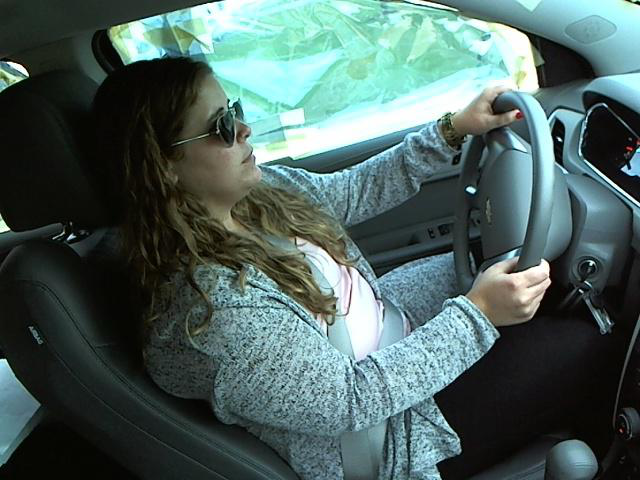

In [32]:
from PIL import Image
img = Image.open(files[0])



## Create simple Convolution model

In [5]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.optimizers import SGD, RMSprop, Adam

Using Theano backend.


In [8]:
model = Sequential()


### Add Input Layer for images with dimension 244 x 244

In [9]:
model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

### Add Convolutional Layers

In [10]:
def ConvBlock(mymodel, layers, filters):
    for i in range(layers):
        mymodel.add(ZeroPadding2D((1,1)))
        mymodel.add(Convolution2D(filters, 3, 3, activation='relu'))
    mymodel.add(MaxPooling2D((2,2), strides=(2,2)))

In [11]:
ConvBlock(model, 2, 64)
ConvBlock(model, 2, 128)
ConvBlock(model, 3, 256)
ConvBlock(model, 3, 512)
ConvBlock(model, 3, 512)

### Add Fully Connected Layers

In [12]:
def FCBlock(mymodel):
    mymodel.add(Dense(4096, activation='relu'))
    mymodel.add(Dropout(0.5))

In [13]:
model.add(Flatten())
FCBlock(model)
FCBlock(model)

### Add final output Dense Layer

In [14]:
model.add(Dense(1000, activation='softmax'))

### Download and load pre-trained model weights from Imagenet

In [15]:
fname = 'vgg16.h5'
baseurl = 'http://www.platform.ai/models/'
local_weights = get_file(fname, baseurl+fname, cache_subdir='models')

In [16]:
model.load_weights(local_weights)

## Finetune VGG16 by replacing last layer with a Dense layer

In [17]:
model.pop()

Make all remaining layers read-only, since we want to leverage all the pre-trained weights

In [18]:
for layer in model.layers: layer.trainable=False

Get batch of data for training and validation

In [19]:
def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
    return gen.flow_from_directory(path, target_size=(224,224), class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [20]:
train_batches = get_batches(path+'train', batch_size=batch_size)
valid_batches = get_batches(path+'valid', batch_size=batch_size)

Found 495 images belonging to 10 classes.
Found 120 images belonging to 10 classes.


### Now add new Dense layer with number of classes we are training with, and compile.

In [21]:
model.add(Dense(train_batches.nb_class, activation='softmax'))

In [22]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### Now fit the model with training and validation batches

In [24]:
model.fit_generator(train_batches, 
                    samples_per_epoch=train_batches.nb_sample,
                    nb_epoch=2,
                    validation_data=valid_batches,
                    nb_val_samples=valid_batches.nb_sample
                   )

Epoch 1/1
495/495 [==============================] - 238s - loss: 6.5452 - acc: 0.2485 - val_loss: 5.6193 - val_acc: 0.2500


In [26]:
model.optimizer.lr=0.0001
model.fit_generator(train_batches, 
                    samples_per_epoch=train_batches.nb_sample,
                    nb_epoch=4,
                    validation_data=valid_batches,
                    nb_val_samples=valid_batches.nb_sample
                   )

Epoch 1/4
495/495 [==============================] - 238s - loss: 5.0569 - acc: 0.3657 - val_loss: 5.4888 - val_acc: 0.1917
Epoch 2/4
495/495 [==============================] - 236s - loss: 4.4836 - acc: 0.4242 - val_loss: 6.6150 - val_acc: 0.3083
Epoch 3/4
495/495 [==============================] - 236s - loss: 4.4030 - acc: 0.4687 - val_loss: 5.4573 - val_acc: 0.2583
Epoch 4/4
495/495 [==============================] - 236s - loss: 4.4733 - acc: 0.4909 - val_loss: 5.0034 - val_acc: 0.3583


In [35]:
# model.save_weights('models/small_sample.h5')

### Generate test predictions

In [24]:
test_batches = get_batches(test_path, shuffle=False, batch_size=2*batch_size, class_mode=None)

Found 100 images belonging to 1 classes.


In [25]:
test_predictions = model.predict_generator(test_batches, test_batches.nb_sample)

### Generate Kaggle submission file

So to play it safe, we use a sneaky trick to round down our edge predictions.
Swap all ones with .95 and all zeros with .05

In [26]:
test_predictions = test_predictions.clip(min=0.05, max=0.95)

Prepare filenames by stripping path

In [27]:
test_filenames = [filename[filename.find('/')+1:] for filename in test_batches.filenames]

Prepare the submission data matrix the dumb way...

In [28]:
subm1 = np.zeros(test_batches.nb_sample, dtype=[('filename', 'S128'), ('c0', float), ('c1', float), ('c2', float), ('c3', float), ('c4', float), ('c5', float), ('c6', float), ('c7', float), ('c8', float), ('c9', float)])

subm1['filename'] = test_filenames

subm1['c0'] = test_predictions[:,0]
subm1['c1'] = test_predictions[:,1]
subm1['c2'] = test_predictions[:,2]
subm1['c3'] = test_predictions[:,3]
subm1['c4'] = test_predictions[:,4]
subm1['c5'] = test_predictions[:,5]
subm1['c6'] = test_predictions[:,6]
subm1['c7'] = test_predictions[:,7]
subm1['c8'] = test_predictions[:,8]
subm1['c9'] = test_predictions[:,9]

Write Kaggle submission file

In [29]:
submission_file_name = 'submission_' + str(int(time())) + '.csv'
np.savetxt(submission_file_name, subm1, fmt='%s,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f', header='img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9', comments='')

### Visualize the prediction by plotting a few

Define function to convert Category ID encoded via bit vector to Category Description from Kaggle's data description page:
* c0: safe driving 
* c1: texting - right 
* c2: talking on the phone - right 
* c3: texting - left 
* c4: talking on the phone - left 
* c5: operating the radio 
* c6: drinking 
* c7: reaching behind 
* c8: hair and makeup 
* c9: talking to passenger

In [30]:
def convertCategetoryIDToTextDescription(category_id):
    return {
        0: 'safe driving',
        1: 'texting - right',
        2: 'talking on the phone - right',
        3: 'texting - left',
        4: 'talking on the phone - left',
        5: 'operating the radio',
        6: 'drinking',
        7: 'reaching behind',
        8: 'hair and makeup',
        9: 'talking to passenger'
    }.get(category_id, 'unknown')

Use argmax to find index with highest probability.
Index happens to be same value as State Farm Cateogry Id itself

In [31]:
test_pred_winning_category_id = test_predictions.argmax(axis=1)
test_pred_winning_categories = [convertCategetoryIDToTextDescription(x) for x in test_pred_winning_category_id]
test_pred_winning_prob = np.choose(test_pred_winning_category_id, test_predictions.transpose())

Helper function to plot images for chosen indices

In [32]:
from utils import plots
    
def plots_idx(idx, path, filenames, categories, probabilities):
    my_image_ids = np.array([int(filenames[i][filenames[i].find('_')+1:filenames[i].find('.')]) for i in idx])
    my_categories = [categories[i] for i in idx]
    my_probabilities = [probabilities[i] for i in idx]
    
    # label = <iamge id>=<probability>:<category>
    my_labels = ["{}={:0.2f}:{}".format(i, j, k) for i,j,k in zip(my_image_ids, my_probabilities, my_categories)]
    
    plots([image.load_img(path + filenames[i]) for i in idx], titles=my_labels)    

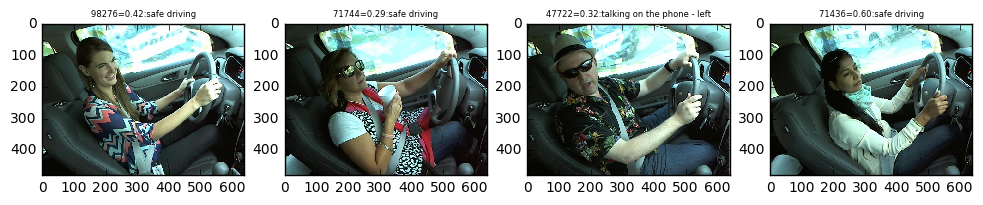

In [33]:
n_view = 4

idx = np.random.permutation(range(0,test_batches.nb_sample))[:n_view]
plots_idx(idx, test_path, test_batches.filenames, test_pred_winning_categories, test_pred_winning_prob)
